In [1]:
import cartopy.feature as feature
import cartopy.crs as ccrs
from calendar import month_abbr
import matplotlib.dates as mdates
from pathlib import Path 
import subprocess 
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import datetime
import numpy as np
import pandas as pd
import xarray
import xesmf
import os 
from glob import glob
from plot_common import autoextend_colorbar, corners, get_map_norm, open_var, add_ticks, annotate_skill, save_figure

In [2]:
from scipy.stats import ttest_1samp
import statistics
import scipy 




                                FUNCTION TO COMPUTE THE GULF STREAM INDEX AND POINTS



In [3]:
def compute_gs(ssh, data_grid=None):
    lons = np.arange(360-72, 360-51.9, 1)
    lats = np.arange(36, 42, 0.1)
    target_grid = {'lat': lats, 'lon': lons}

    if data_grid is None:
        data_grid = {'lat': ssh.lat, 'lon': ssh.lon}

    ssh_to_grid = xesmf.Regridder(
        data_grid,
        target_grid,
        method='bilinear'
    )

    # Interpolate the SSH data onto the index grid.
    regridded = ssh_to_grid(ssh)

    # Find anomalies relative to the calendar month mean SSH over the full model run.
    anom = regridded.groupby('time.month') - regridded.groupby('time.month').mean('time')

    # For each longitude point, the Gulf Stream is located at the latitude with the maximum SSH anomaly variance.
    stdev = anom.std('time')
    amax = stdev.argmax('lat').compute()
    gs_points = stdev.lat.isel(lat=amax).compute()

    # The index is the mean latitude of the Gulf Stream, divided by the standard deviation of the mean latitude of the Gulf Stream.
    index = ((anom.isel(lat=amax).mean('lon')) / anom.isel(lat=amax).mean('lon').std('time')).compute()

    # Move times to the beginning of the month to match observations.
    monthly_index = index.to_pandas().resample('1MS').first()
    return monthly_index, gs_points


                                        
                                        
                                        FUNCTION TO OPEN NETCDF FILES 

In [4]:
def open_var(pp_root, kind, var):
    freq = 'daily' if 'daily' in kind else 'monthly'
    longslice = '19930101-19981231' if freq == 'daily' else '199301-199812'
    longfile = os.path.join(pp_root, 'pp', kind, 'ts', freq, '5yr', f'{kind}.{longslice}.{var}.nc')
    if os.path.isfile(longfile):
        os.system(f'dmget {longfile}')
        return xarray.open_dataset(longfile)[var]
    elif len(glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '1yr', f'{kind}.*.{var}.nc'))) > 0:
        files = glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '1yr', f'{kind}.*.{var}.nc'))
        os.system(f'dmget {" ".join(files)}')
        return xarray.open_mfdataset(files)[var]
    elif len(glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '5yr', f'{kind}.*.{var}.nc'))) > 0:
        files = glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '5yr', f'{kind}.*.{var}.nc'))
        os.system(f'dmget {" ".join(files)}')
        return xarray.open_mfdataset(files)[var]
    else:
        raise Exception('Did not find postprocessed files')


                                                
                                                
                                                
                                            OBSERVED DATA AND MODELS

In [5]:
obs_sst = xarray.open_mfdataset('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.nc')['sst']
obs_ssh_points = xarray.open_mfdataset('/home/Andrew.C.Ross/git/nwa12/experiments/COBALT_2023_04/data/satellite_ssh_points.nc') 
obs_ssh_indexes = pd.read_pickle('/home/Andrew.C.Ross/git/nwa12/experiments/COBALT_2023_04/data/satellite_ssh_index.pkl').resample('1YS').mean()

In [6]:
model_grid = xarray.open_dataset('../data/geography/ocean_static.nc')
obs_sst_grid = xarray.open_mfdataset('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.grid.nc')  

In [7]:
obsregrd = xesmf.Regridder(obs_sst_grid, {'lat': model_grid.geolat, 'lon': model_grid.geolon}, 
        method='bilinear', 
        unmapped_to_nan=True)

obs_regriddeda = obsregrd(obs_sst)
obs_regridded = obs_regriddeda.sel(time=slice('1993','2007'))

In [8]:
rootmed1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod') 
rootlow1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_1/gfdl.ncrc5-intel22-prod')
rootmed2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_2/gfdl.ncrc5-intel22-prod') 
rootlow2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_2/gfdl.ncrc5-intel22-prod')
rootmed3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_3/gfdl.ncrc5-intel22-prod') 
rootlow3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_3/gfdl.ncrc5-intel22-prod')
rootmed4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_4/gfdl.ncrc5-intel22-prod') 
rootlow4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_4/gfdl.ncrc5-intel22-prod')
rootmed5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_5/gfdl.ncrc5-intel22-prod') 
rootlow5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_5/gfdl.ncrc5-intel22-prod')


                                            
                                            
                                            
                                            GRABBING VARS

In [9]:
sstwholemed1 = open_var(rootmed1, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholelow1 = open_var(rootlow1, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholemed2 = open_var(rootmed2, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholelow2 = open_var(rootlow2, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007"))
sstwholemed3 = open_var(rootmed3, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholelow3 = open_var(rootlow3, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholemed4 = open_var(rootmed4, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007"))  
sstwholelow4 = open_var(rootlow4, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholemed5 = open_var(rootmed5, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007"))  
sstwholelow5 = open_var(rootlow5, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 

In [10]:
sshwholemed1 = open_var(rootmed1, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow1 = open_var(rootlow1, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholemed2 = open_var(rootmed2, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow2 = open_var(rootlow2, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholemed3 = open_var(rootmed3, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow3 = open_var(rootlow3, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholemed4 = open_var(rootmed4, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow4 = open_var(rootlow4, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholemed5 = open_var(rootmed5, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow5 = open_var(rootlow5, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 

In [11]:
modelgsiindexmed1, modelgsipointsmed1 = compute_gs(sshwholemed1, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow1, modelgsipointslow1 = compute_gs(sshwholelow1, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed2, modelgsipointsmed2 = compute_gs(sshwholemed2, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow2, modelgsipointslow2 = compute_gs(sshwholelow2, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed3, modelgsipointsmed3 = compute_gs(sshwholemed3, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow3, modelgsipointslow3 = compute_gs(sshwholelow3, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed4, modelgsipointsmed4 = compute_gs(sshwholemed4, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow4, modelgsipointslow4 = compute_gs(sshwholelow4, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed5, modelgsipointsmed5 = compute_gs(sshwholemed5, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow5, modelgsipointslow5 = compute_gs(sshwholelow5, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order in

In [11]:
masks = xarray.open_dataset('/home/Andrew.C.Ross/git/nwa12/data/geography/masks/regions_30m.nc') 

In [12]:
weights_gom = masks['areacello'].where(masks['GOM']).fillna(0) 
weights_neus = masks['areacello'].where(masks['NEUS_LME']).fillna(0)
weights_mab = masks['areacello'].where(masks['MAB']).fillna(0) 

In [13]:
mean_sst_neus_obs = obs_regridded.weighted(weights_neus).mean(['yh', 'xh'])
mean_sst_gom_obs = obs_regridded.weighted(weights_gom).mean(['yh', 'xh']) 
mean_sst_mab_obs = obs_regridded.weighted(weights_mab).mean(['yh', 'xh']) 

In [14]:
annual_neus_obs = mean_sst_neus_obs.resample(time='1YS').mean() 
annual_gom_obs = mean_sst_gom_obs.resample(time='1YS').mean() 
annual_mab_obs = mean_sst_mab_obs.resample(time='1YS').mean() 

In [15]:
mean_sst_neus_med1 = sstwholemed1.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low1 = sstwholelow1.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_med2 = sstwholemed2.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low2 = sstwholelow2.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_med3 = sstwholemed3.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low3 = sstwholelow3.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_med4 = sstwholemed4.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low4 = sstwholelow4.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_med5 = sstwholemed5.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low5 = sstwholelow5.weighted(weights_neus).mean(['yh', 'xh']).compute() 

In [16]:
mean_sst_gom_med1 = sstwholemed1.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_low1 = sstwholelow1.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_med2 = sstwholemed2.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_low2 = sstwholelow2.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_med3 = sstwholemed3.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_low3 = sstwholelow3.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_med4 = sstwholemed4.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_low4 = sstwholelow4.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_med5 = sstwholemed5.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_low5 = sstwholelow5.weighted(weights_gom).mean(['yh', 'xh']).compute() 

In [17]:
mean_sst_mab_med1 = sstwholemed1.weighted(weights_mab).mean(['yh', 'xh']).compute() 
mean_sst_mab_low1 = sstwholelow1.weighted(weights_mab).mean(['yh', 'xh']).compute() 
mean_sst_mab_med2 = sstwholemed2.weighted(weights_mab).mean(['yh', 'xh']).compute() 
mean_sst_mab_low2 = sstwholelow2.weighted(weights_mab).mean(['yh', 'xh']).compute() 
mean_sst_mab_med3 = sstwholemed3.weighted(weights_mab).mean(['yh', 'xh']).compute() 
mean_sst_mab_low3 = sstwholelow3.weighted(weights_mab).mean(['yh', 'xh']).compute() 
mean_sst_mab_med4 = sstwholemed4.weighted(weights_mab).mean(['yh', 'xh']).compute() 
mean_sst_mab_low4 = sstwholelow4.weighted(weights_mab).mean(['yh', 'xh']).compute() 
mean_sst_mab_med5 = sstwholemed5.weighted(weights_mab).mean(['yh', 'xh']).compute() 
mean_sst_mab_low5 = sstwholelow5.weighted(weights_mab).mean(['yh', 'xh']).compute() 

In [19]:
annual_gsi_index_med1 = modelgsiindexmed1.resample('1YS').mean()
annual_gsi_index_low1 = modelgsiindexlow1.resample('1YS').mean()
annual_gsi_index_med2 = modelgsiindexmed2.resample('1YS').mean()
annual_gsi_index_low2 = modelgsiindexlow2.resample('1YS').mean()
annual_gsi_index_med3 = modelgsiindexmed3.resample('1YS').mean()
annual_gsi_index_low3 = modelgsiindexlow3.resample('1YS').mean()
annual_gsi_index_med4 = modelgsiindexmed4.resample('1YS').mean()
annual_gsi_index_low4 = modelgsiindexlow4.resample('1YS').mean()
annual_gsi_index_med5 = modelgsiindexmed5.resample('1YS').mean()
annual_gsi_index_low5 = modelgsiindexlow5.resample('1YS').mean()

In [20]:
annual_neus_med1 = mean_sst_neus_med1.resample(time='1YS').mean()
annual_neus_low1 = mean_sst_neus_low1.resample(time='1YS').mean()
annual_neus_med2 = mean_sst_neus_med2.resample(time='1YS').mean()
annual_neus_low2 = mean_sst_neus_low2.resample(time='1YS').mean()
annual_neus_med3 = mean_sst_neus_med3.resample(time='1YS').mean()
annual_neus_low3 = mean_sst_neus_low3.resample(time='1YS').mean()
annual_neus_med4 = mean_sst_neus_med4.resample(time='1YS').mean()
annual_neus_low4 = mean_sst_neus_low4.resample(time='1YS').mean()
annual_neus_med5 = mean_sst_neus_med5.resample(time='1YS').mean()
annual_neus_low5 = mean_sst_neus_low5.resample(time='1YS').mean()

In [21]:
annual_gom_med1 = mean_sst_gom_med1.resample(time='1YS').mean()
annual_gom_low1 = mean_sst_gom_low1.resample(time='1YS').mean()
annual_gom_med2 = mean_sst_gom_med2.resample(time='1YS').mean()
annual_gom_low2 = mean_sst_gom_low2.resample(time='1YS').mean()
annual_gom_med3 = mean_sst_gom_med3.resample(time='1YS').mean()
annual_gom_low3 = mean_sst_gom_low3.resample(time='1YS').mean()
annual_gom_med4 = mean_sst_gom_med4.resample(time='1YS').mean()
annual_gom_low4 = mean_sst_gom_low4.resample(time='1YS').mean()
annual_gom_med5 = mean_sst_gom_med5.resample(time='1YS').mean()
annual_gom_low5 = mean_sst_gom_low5.resample(time='1YS').mean()

In [22]:
annual_mab_med1 = mean_sst_mab_med1.resample(time='1YS').mean()
annual_mab_low1 = mean_sst_mab_low1.resample(time='1YS').mean()
annual_mab_med2 = mean_sst_mab_med2.resample(time='1YS').mean()
annual_mab_low2 = mean_sst_mab_low2.resample(time='1YS').mean()
annual_mab_med3 = mean_sst_mab_med3.resample(time='1YS').mean()
annual_mab_low3 = mean_sst_mab_low3.resample(time='1YS').mean()
annual_mab_med4 = mean_sst_mab_med4.resample(time='1YS').mean()
annual_mab_low4 = mean_sst_mab_low4.resample(time='1YS').mean()
annual_mab_med5 = mean_sst_mab_med5.resample(time='1YS').mean()
annual_mab_low5 = mean_sst_mab_low5.resample(time='1YS').mean()

In [23]:
annual_neus_obs_corr = xarray.corr(annual_neus_obs.sel(time=slice('1995', '2007')).load(), pd.DataFrame.to_xarray(obs_ssh_indexes).sel(time=slice('1995', '2007')), dim='time').item()
annual_gom_obs_corr = xarray.corr(annual_gom_obs.sel(time=slice('1995', '2007')).load(), pd.DataFrame.to_xarray(obs_ssh_indexes).sel(time=slice('1995', '2007')), dim='time').item()
annual_mab_obs_corr = xarray.corr(annual_mab_obs.sel(time=slice('1995', '2007')).load(), pd.DataFrame.to_xarray(obs_ssh_indexes).sel(time=slice('1995', '2007')), dim='time').item()

In [24]:
annual_neus_low1_corr = xarray.corr(annual_neus_low1.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low1), dim='time').item() 
annual_neus_med1_corr = xarray.corr(annual_neus_med1.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med1), dim='time').item() 
annual_neus_low2_corr = xarray.corr(annual_neus_low2.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low2), dim='time').item() 
annual_neus_med2_corr = xarray.corr(annual_neus_med2.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med2), dim='time').item() 
annual_neus_low3_corr = xarray.corr(annual_neus_low3.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low3), dim='time').item() 
annual_neus_med3_corr = xarray.corr(annual_neus_med3.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med3), dim='time').item() 
annual_neus_low4_corr = xarray.corr(annual_neus_low4.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low4), dim='time').item() 
annual_neus_med4_corr = xarray.corr(annual_neus_med4.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med4), dim='time').item() 
annual_neus_low5_corr = xarray.corr(annual_neus_low5.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low5), dim='time').item() 
annual_neus_med5_corr = xarray.corr(annual_neus_med5.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med5), dim='time').item() 

In [25]:
annual_gom_low1_corr = xarray.corr(annual_gom_low1.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low1), dim='time').item() 
annual_gom_med1_corr = xarray.corr(annual_gom_med1.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med1), dim='time').item() 
annual_gom_low2_corr = xarray.corr(annual_gom_low2.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low2), dim='time').item() 
annual_gom_med2_corr = xarray.corr(annual_gom_med2.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med2), dim='time').item() 
annual_gom_low3_corr = xarray.corr(annual_gom_low3.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low3), dim='time').item() 
annual_gom_med3_corr = xarray.corr(annual_gom_med3.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med3), dim='time').item() 
annual_gom_low4_corr = xarray.corr(annual_gom_low4.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low4), dim='time').item() 
annual_gom_med4_corr = xarray.corr(annual_gom_med4.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med4), dim='time').item() 
annual_gom_low5_corr = xarray.corr(annual_gom_low5.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low5), dim='time').item() 
annual_gom_med5_corr = xarray.corr(annual_gom_med5.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med5), dim='time').item() 

In [26]:
annual_mab_low1_corr = xarray.corr(annual_mab_low1.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low1), dim='time').item() 
annual_mab_med1_corr = xarray.corr(annual_mab_med1.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med1), dim='time').item() 
annual_mab_low2_corr = xarray.corr(annual_mab_low2.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low2), dim='time').item() 
annual_mab_med2_corr = xarray.corr(annual_mab_med2.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med2), dim='time').item() 
annual_mab_low3_corr = xarray.corr(annual_mab_low3.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low3), dim='time').item() 
annual_mab_med3_corr = xarray.corr(annual_mab_med3.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med3), dim='time').item() 
annual_mab_low4_corr = xarray.corr(annual_mab_low4.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low4), dim='time').item() 
annual_mab_med4_corr = xarray.corr(annual_mab_med4.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med4), dim='time').item() 
annual_mab_low5_corr = xarray.corr(annual_mab_low5.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low5), dim='time').item() 
annual_mab_med5_corr = xarray.corr(annual_mab_med5.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med5), dim='time').item() 

In [27]:
lowcorrs = [(annual_neus_low1_corr,1),(annual_neus_low2_corr,2),(annual_neus_low3_corr,3), (annual_neus_low4_corr,4), (annual_neus_low5_corr,5) ]
medcorrs = [(annual_neus_med1_corr,1), (annual_neus_med2_corr,2), (annual_neus_med3_corr,3), (annual_neus_med4_corr,4), (annual_neus_med5_corr,5) ]

In [28]:
lowcorrsgom = [(annual_gom_low1_corr,1), (annual_gom_low2_corr,2), (annual_gom_low3_corr,3), (annual_gom_low4_corr,4), (annual_gom_low5_corr,5)]
medcorrsgom = [(annual_gom_med1_corr,1), (annual_gom_med2_corr,2), (annual_gom_med3_corr,3), (annual_gom_med4_corr,4), (annual_gom_med5_corr,5)]

In [29]:
lowcorrsmab = [(annual_mab_low1_corr,1), (annual_mab_low2_corr,2), (annual_mab_low3_corr,3), (annual_mab_low4_corr,4), (annual_mab_low5_corr,5)]
medcorrsmab = [(annual_mab_med1_corr,1), (annual_mab_med2_corr,2), (annual_mab_med3_corr,3), (annual_mab_med4_corr,4), (annual_mab_med5_corr,5)]

In [30]:
annual_neus_obs_corr

0.46763337005438305

In [31]:
annual_gom_obs_corr

0.40133468167962494

In [32]:
annual_mab_obs_corr

0.45297028685367174

In [33]:
annual_neus_low1_corr

-0.6267034016274918

In [34]:
annual_gom_low1_corr

-0.7026934484357419

Text(0, 0.5, 'Correlation Coefficient')

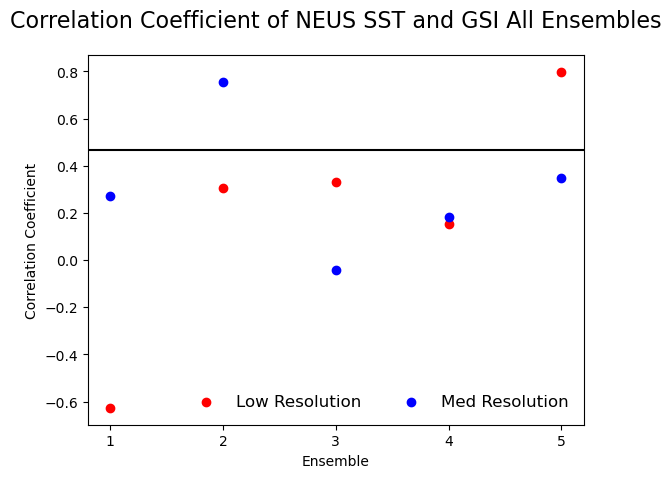

In [35]:
lowcorrsptsx = [x[0] for x in lowcorrs]
lowcorrsptsy = [x[1] for x in lowcorrs] 
medcorrsptsx = [x[0] for x in medcorrs]
medcorrsptsy = [x[1] for x in medcorrs]
plt.title('Correlation Coefficient of NEUS SST and GSI All Ensembles', fontsize='16', pad='20') 
plt.scatter(lowcorrsptsy, lowcorrsptsx, c='r', label='Low Resolution')
plt.scatter(medcorrsptsy, medcorrsptsx, c='b', label='Med Resolution')
plt.axhline(y = annual_neus_obs_corr, color = "black")
plt.xticks([1,2,3,4,5], ['1', '2', '3', '4', '5']) 
plt.legend(ncol=4, loc='lower right', frameon=False, fontsize=12, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.xlabel('Ensemble') 
plt.ylabel('Correlation Coefficient') 

Text(0, 0.5, 'Correlation Coefficient')

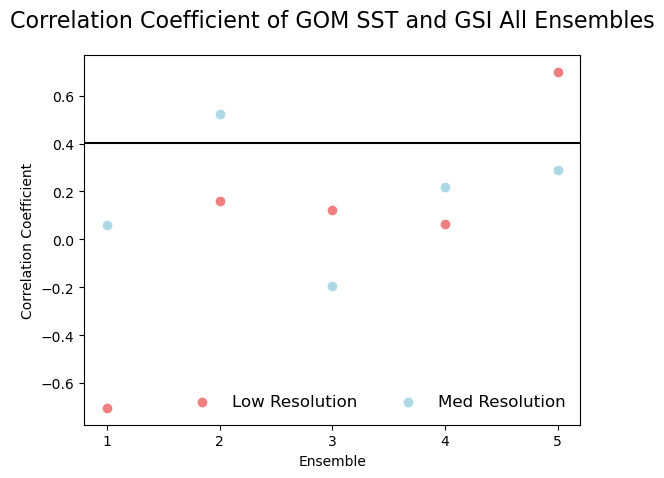

In [36]:
lowcorrsptsgomx = [x[0] for x in lowcorrsgom]
lowcorrsptsgomy = [x[1] for x in lowcorrsgom] 
medcorrsptsgomx = [x[0] for x in medcorrsgom]
medcorrsptsgomy = [x[1] for x in medcorrsgom]
plt.title('Correlation Coefficient of GOM SST and GSI All Ensembles', fontsize='16', pad='20') 
plt.scatter(lowcorrsptsgomy, lowcorrsptsgomx, c='lightcoral', label='Low Resolution')
plt.scatter(medcorrsptsgomy, medcorrsptsgomx, c='lightblue', label='Med Resolution')
plt.axhline(y = annual_gom_obs_corr, color = "black")
plt.xticks([1,2,3,4,5], ['1', '2', '3', '4', '5']) 
plt.legend(ncol=4, loc='lower right', frameon=False, fontsize=12, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.xlabel('Ensemble') 
plt.ylabel('Correlation Coefficient') 

Text(0, 0.5, 'Correlation Coefficient')

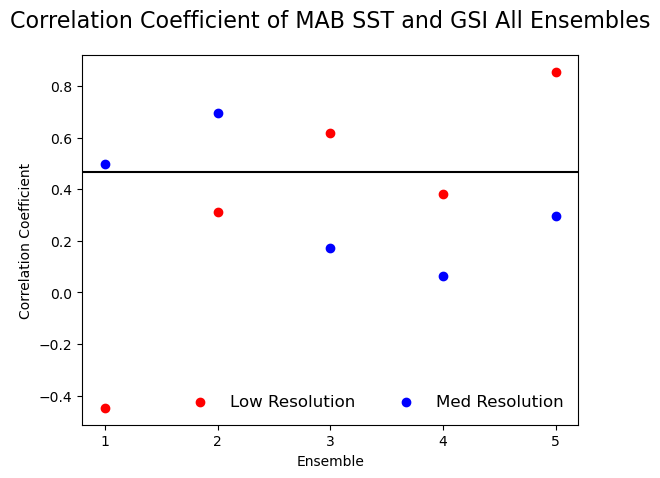

In [37]:
lowcorrsptsxmab = [x[0] for x in lowcorrsmab]
lowcorrsptsymab = [x[1] for x in lowcorrsmab] 
medcorrsptsxmab = [x[0] for x in medcorrsmab]
medcorrsptsymab = [x[1] for x in medcorrsmab]
plt.title('Correlation Coefficient of MAB SST and GSI All Ensembles', fontsize='16', pad='20') 
plt.scatter(lowcorrsptsymab, lowcorrsptsxmab, c='r', label='Low Resolution')
plt.scatter(medcorrsptsymab, medcorrsptsxmab, c='b', label='Med Resolution')
plt.axhline(y = annual_neus_obs_corr, color = "black")
plt.xticks([1,2,3,4,5], ['1', '2', '3', '4', '5']) 
plt.legend(ncol=4, loc='lower right', frameon=False, fontsize=12, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.xlabel('Ensemble') 
plt.ylabel('Correlation Coefficient') 

In [38]:
nullhypothesisvaluegom = annual_gom_obs_corr
corrlowgom = np.array(lowcorrsptsgomx)
corrmedgom = np.array(medcorrsptsgomx)
t_obslowgom, p_valuelowgom = ttest_1samp(corrlowgom, nullhypothesisvaluegom)
t_obsmedgom, p_valuemedgom = ttest_1samp(corrmedgom, nullhypothesisvaluegom)

In [39]:
p_valuelowgom

0.2111063058333432

In [40]:
p_valuemedgom

0.1362721533582231

In [41]:
nullhypothesisvalue = annual_neus_obs_corr
corrlow = np.array(lowcorrsptsx)
corrmed = np.array(medcorrsptsx)
t_obslow, p_valuelow = ttest_1samp(corrlow, nullhypothesisvalue)
t_obsmed, p_valuemed = ttest_1samp(corrmed, nullhypothesisvalue)

In [42]:
t_statisticlow = scipy.stats.t.ppf(1-0.05, 4)

In [43]:
t_statisticmed = scipy.stats.t.ppf(1-0.05, 4)

In [44]:
p_valuelow

0.3013338481910916

In [45]:
p_valuemed

0.27529215242728444

In [46]:
nullhypothesisvaluemab = annual_mab_obs_corr
corrlowmab = np.array(lowcorrsptsxmab)
corrmedmab = np.array(medcorrsptsxmab)
t_obslowmab, p_valuelowmab = ttest_1samp(corrlowmab, nullhypothesisvaluemab)
t_obsmedmab, p_valuemedmab = ttest_1samp(corrmedmab, nullhypothesisvaluemab)

In [47]:
p_valuelowmab

0.6472271566044193

In [48]:
p_valuemedmab

0.39475938817006606

In [49]:
lowcorravg = (annual_neus_low1_corr + annual_neus_low2_corr + annual_neus_low3_corr + annual_neus_low4_corr + annual_neus_low5_corr)/5
medcorravg = (annual_neus_med1_corr + annual_neus_med2_corr + annual_neus_med3_corr + annual_neus_med4_corr + annual_neus_med5_corr)/5

In [50]:
lowcorravggom = (annual_gom_low1_corr + annual_gom_low2_corr + annual_gom_low3_corr + annual_gom_low4_corr + annual_gom_low5_corr)/5
medcorravggom = (annual_gom_med1_corr + annual_gom_med2_corr + annual_gom_med3_corr + annual_gom_med4_corr + annual_gom_med5_corr)/5

In [51]:
lowcorravg 

0.1931230873563547

In [52]:
lowcorrerror = abs(t_statisticlow * (statistics.stdev([annual_neus_low1_corr, annual_neus_low2_corr, annual_neus_low3_corr, annual_neus_low4_corr, annual_neus_low5_corr])/(5**.5)))

In [53]:
lowcorrerrorgom = abs(t_statisticlow * (statistics.stdev([annual_gom_low1_corr, annual_gom_low2_corr, annual_gom_low3_corr, annual_gom_low4_corr, annual_gom_low5_corr])/(5**.5)))

In [54]:
t_statisticlow

2.131846786326649

In [55]:
lowcorrerror

0.49352550902736203

In [56]:
medcorravg

0.30304695161821715

In [57]:
medcorrerror = abs(t_statisticmed * (statistics.stdev([annual_neus_med1_corr, annual_neus_med2_corr, annual_neus_med3_corr, annual_neus_med4_corr, annual_neus_med5_corr])/(5**.5)))

In [58]:
medcorrerrorgom = abs(t_statisticmed * (statistics.stdev([annual_gom_med1_corr, annual_gom_med2_corr, annual_gom_med3_corr, annual_gom_med4_corr, annual_gom_med5_corr])/(5**.5)))

In [59]:
medcorrerror

0.27787491775860185

Text(1.7, -0.15, 'p-value: 0.275')

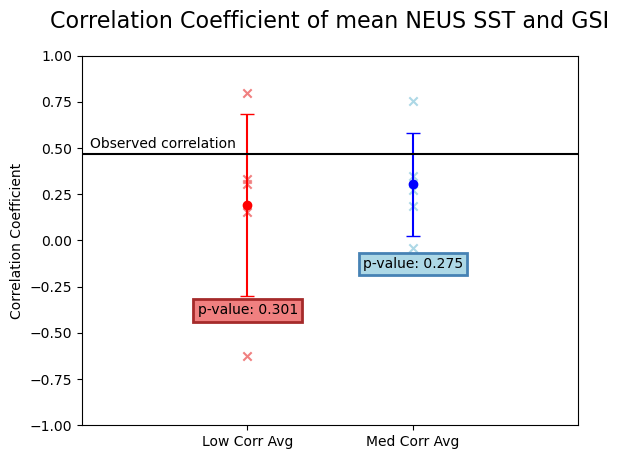

In [60]:
plt.title('Correlation Coefficient of mean NEUS SST and GSI', fontsize='16', pad='20') 
plt.errorbar(2, medcorravg, yerr=np.array([medcorrerror]), fmt='o', capsize=5, c='b')
plt.errorbar(1, lowcorravg, yerr=np.array([lowcorrerror]), fmt='o', capsize=5, c='r')
plt.xlim(0,3) 
plt.ylim(-1,1) 
plt.xticks([1, 2], ['Low Corr Avg', 'Med Corr Avg'])
plt.ylabel('Correlation Coefficient') 
plt.axhline(y = annual_neus_obs_corr, color = "black")
plt.annotate('Observed correlation', (.05,.5)) 
plt.scatter([1,1,1,1,1], lowcorrsptsx, c='lightcoral', label='Low Resolution',marker='x')
plt.scatter([2,2,2,2,2], medcorrsptsx, c='lightblue', label='Med Resolution', marker='x')
plt.annotate(f'p-value: {float(str(p_valuelow)[:5])}', (.7, -.4), bbox=dict(boxstyle="square,pad=0.3", fc="lightcoral", ec="brown", lw=2))
plt.annotate(f'p-value: {float(str(p_valuemed)[:5])}', (1.7, -.15), bbox=dict(boxstyle="square,pad=0.3", fc="lightblue", ec="steelblue", lw=2))

Text(1.7, -0.5, 'p-value: 0.136')

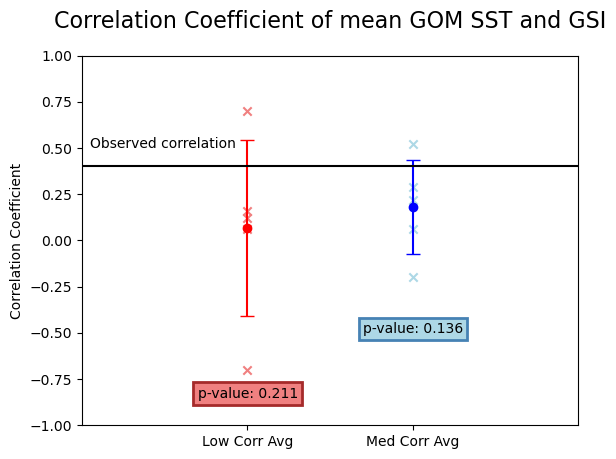

In [61]:
plt.title('Correlation Coefficient of mean GOM SST and GSI', fontsize='16', pad='20') 
plt.errorbar(2, medcorravggom, yerr=np.array([medcorrerrorgom]), fmt='o', capsize=5, c='b')
plt.errorbar(1, lowcorravggom, yerr=np.array([lowcorrerrorgom]), fmt='o', capsize=5, c='r')
plt.xlim(0,3) 
plt.ylim(-1,1) 
plt.xticks([1, 2], ['Low Corr Avg', 'Med Corr Avg'])
plt.ylabel('Correlation Coefficient') 
plt.axhline(y = annual_gom_obs_corr, color = "black")
plt.annotate('Observed correlation', (.05,.5))
plt.scatter([1,1,1,1,1], lowcorrsptsgomx, c='lightcoral', label='Low Resolution',marker='x')
plt.scatter([2,2,2,2,2], medcorrsptsgomx, c='lightblue', label='Med Resolution', marker='x')
plt.annotate(f'p-value: {float(str(p_valuelowgom)[:5])}', (.7, -.85), bbox=dict(boxstyle="square,pad=0.3", fc="lightcoral", ec="brown", lw=2))
plt.annotate(f'p-value: {float(str(p_valuemedgom)[:5])}', (1.7, -.5), bbox=dict(boxstyle="square,pad=0.3", fc="lightblue", ec="steelblue", lw=2))

In [62]:
medmembers = []
nens = 5
for ens in range(1, nens+1):
    root = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_{ens}/gfdl.ncrc5-intel22-prod')
    mld = open_var(root, 'ocean_monthly', 'ssh')
    medmembers.append(mld)

all_members_med = xarray.concat(medmembers, dim='member')

In [63]:
type(all_members_med) 

xarray.core.dataarray.DataArray

In [64]:
all_members_med 

<xarray.DataArray 'ssh' (member: 5, time: 360, yh: 845, xh: 775)> Size: 5GB
dask.array<concatenate, shape=(5, 360, 845, 775), dtype=float32, chunksize=(1, 60, 845, 775), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2022-12-16T12:...
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93
Dimensions without coordinates: member
Attributes:
    units:          m
    long_name:      Sea Surface Height
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


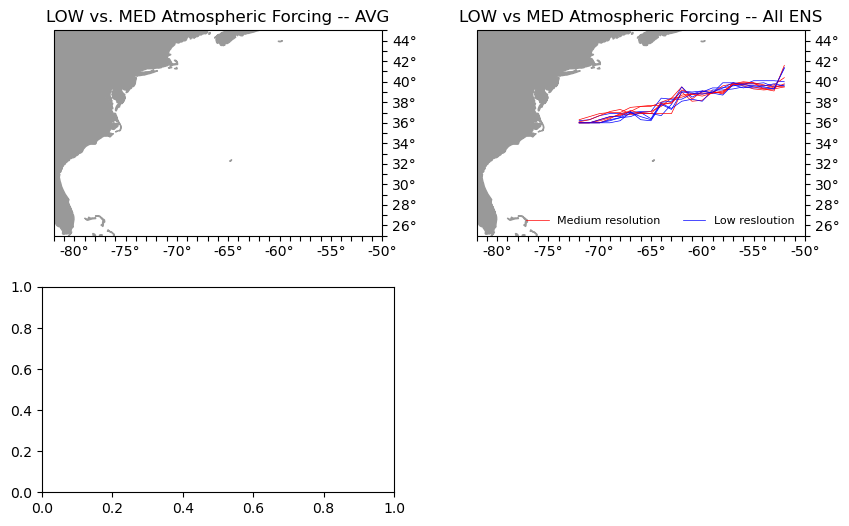

In [65]:
    fig = plt.figure(figsize=(10, 6), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, hspace=.25)
    PC = ccrs.PlateCarree()
    _LAND_50M = feature.NaturalEarthFeature(
    'physical', 'land', '50m',
    edgecolor='face',
    facecolor='#999999'
    )

    ax = fig.add_subplot(gs[0, 0], projection=PC)
    ax.add_feature(_LAND_50M)
    ax.plot(obs_ssh_points.lat-360, obs_ssh_points.lon) 
    add_ticks(ax, xlabelinterval=5)
    ax.set_extent([-82, -50, 25, 44])
    ax.set_title('LOW vs. MED Atmospheric Forcing -- AVG')
    ax.legend(ncol=4, loc='lower right', frameon=False, fontsize=8)

    ax = fig.add_subplot(gs[0, 1], projection=PC)
    ax.add_feature(_LAND_50M)
    ax.plot(modelgsipointsmed1.lon-360, modelgsipointsmed1, c='r', linewidth='.5', label = 'Medium resolution')
    ax.plot(modelgsipointslow1.lon-360, modelgsipointslow1, c='b', linewidth='.5', label = 'Low resloution') 
    ax.plot(modelgsipointsmed2.lon-360, modelgsipointsmed2, c='r', linewidth='.5')
    ax.plot(modelgsipointslow2.lon-360, modelgsipointslow2, c='b', linewidth='.5') 
    ax.plot(modelgsipointsmed3.lon-360, modelgsipointsmed3, c='r', linewidth='.5')
    ax.plot(modelgsipointslow3.lon-360, modelgsipointslow3, c='b', linewidth='.5') 
    ax.plot(modelgsipointsmed4.lon-360, modelgsipointsmed4, c='r', linewidth='.5')
    ax.plot(modelgsipointslow4.lon-360, modelgsipointslow4, c='b', linewidth='.5') 
    ax.plot(modelgsipointsmed5.lon-360, modelgsipointsmed5, c='r', linewidth='.5')
    ax.plot(modelgsipointslow5.lon-360, modelgsipointslow5, c='b', linewidth='.5')
    add_ticks(ax, xlabelinterval=5)
    ax.legend(ncol=4, loc='lower right', frameon=False, fontsize=8)
    ax.set_extent([-82, -50, 25, 44])
    ax.set_title('LOW vs MED Atmospheric Forcing -- All ENS')

    ax = fig.add_subplot(gs[1,0]) 
    

In [66]:
from functools import reduce
# also import pandas, xarray, etc as usual

def shift_time_to_end(before, on):
    """
    Given two xarray dataarrays/sets, both 
    with same frequency and an index named time,
    this will add an appropriate number of years to
    the second (on) so that the time begins after
    the first (before). 
    """
    delta_years = int(before['time.year'][-1]) - int(on['time.year'][0]) + 1
    shifted = on.assign_coords(time=on.indexes['time'] + pd.DateOffset(years=delta_years))
    return shifted

nens = 5
res = 'med'
members = []
for ens in range(1, nens+1):
    root = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_{res}atm_ens_{ens}/gfdl.ncrc5-intel22-prod')
    ssh = open_var(root, 'ocean_monthly', 'ssh').sel(time=slice('1997', None))
    members.append(ssh)
allconcat = reduce(lambda left, right: xarray.concat((left, shift_time_to_end(left, right)), dim='time'), members)